In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

In [2]:
df = pd.read_csv('data/schweidtmann.csv')

In [3]:
df["strategy"] = "LHS"
df.loc[20:, "strategy"] = "TSEMO"

In [4]:
def pareto_efficient(data, maximize=True):
    """
    Copied from Summit, which in turn was probably copied from Stackoverflow
    Find the pareto-efficient points
    Parameters
    ---------
    data: array-like
        An (n_points, n_data) array
    maximize: bool, optional
        Whether the problem is a maximization or minimization problem.
        Defaults to maximization (i.e,. True)
    Returns
    -------
    data, indices:
        data is an array with the pareto front values
        indices is an array with the indices of the pareto points in the original data array
    """
    indices = np.arange(data.shape[0])
    next_point_index = 0  # Next index in the indices array to search for
    while next_point_index < len(data):
        if maximize:
            nondominated_point_mask = np.any(data > data[next_point_index], axis=1)
        else:
            nondominated_point_mask = np.any(data < data[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        indices = indices[nondominated_point_mask]  # Remove dominated points
        data = data[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index]) + 1
    return data, indices


In [5]:
arr = df[["STY/kg m-3 h-1", "% Impurity"]].to_numpy()
arr[:, 1] *= -1.0
pareto, indices = pareto_efficient(arr, maximize=True)
pareto[:,1] *= -1.0
pareto = np.sort(pareto, axis=0)

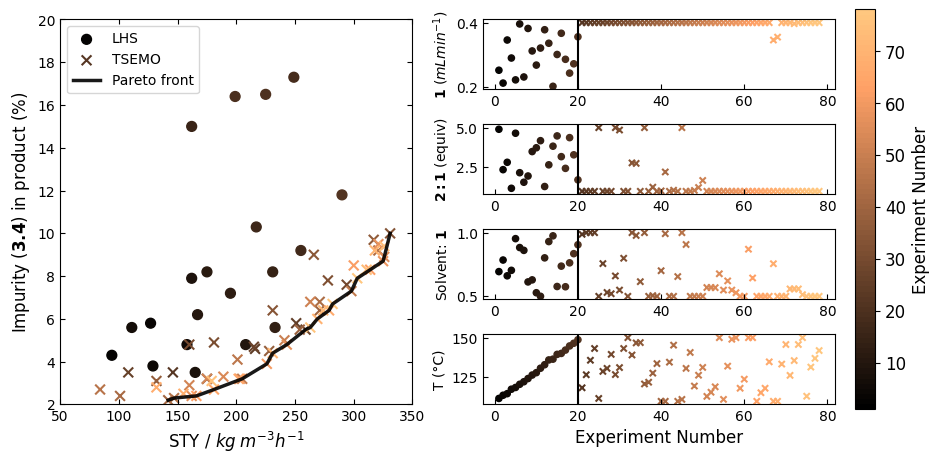

In [9]:
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(hspace=0.5)
fontsize=12

# Pareto plot
ax = fig.add_subplot(1, 2, 1)
markers=["o", "x"]
# Original was copper
cmap = plt.get_cmap("copper", len(df))
for i, strategy in enumerate(["LHS", "TSEMO"]):
    tmp = df[df["strategy"]==strategy]
    colors = cmap(tmp["Entry"].to_numpy())
    ax.scatter(
        data=tmp,
        x="STY/kg m-3 h-1", 
        y="% Impurity",
        # ax=ax,
        label=strategy,
        marker=markers[i],
        s=50,
        c=colors
    )
ax.plot(pareto[:,0], pareto[:,1], linewidth=2.5, color="k",alpha=0.9, label="Pareto front")
ax.set_xlim(50, 350)
ax.set_ylim(2, 20)
ax.legend(loc="upper left")
ax.set_xlabel(r"STY / $kg \; m^{-3} h^{-1}$", fontsize=fontsize)
ax.set_ylabel(r"Impurity ($\bf 3.4$) in product (%)", fontsize=fontsize)
ax.tick_params(direction="in", which="both", right="on", top="on")

# Decision variables
decision_vars = ["6/mL min-1", "7:06", "Solvent:6", "Temp/°C"]
ylabels = [
    r"$\bf 1$ $(mL min^{-1})$",
    r"$\bf 2:1$ (equiv)",
    r"Solvent: $\bf 1$",
    "T (°C)"
]
for i, dv  in enumerate(decision_vars):
    ax = fig.add_subplot(4,2,2*(i+1))
    for j, strategy in enumerate(["LHS", "TSEMO"]):
        tmp = df[df["strategy"]==strategy]
        colors = cmap(tmp["Entry"].to_numpy())
        tmp.plot.scatter("Entry", dv, marker=markers[j], ax=ax, c=colors)
    ax.set_xlabel("")
    ax.tick_params(direction="in")
    ax.set_ylabel(ylabels[i])
    ax.axvline(20, color="k")
ax.set_xlabel("Experiment Number", fontsize=12)


# colorbar
cax = plt.axes([0.92, 0.1, 0.02, 0.8])
norm = Normalize(vmin=1, vmax=len(df))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm,cax=cax,)
cbar.set_label(label="Experiment Number", size=12)
cax.tick_params(labelsize='large')
# cax.yaxis.set_ticks_position('left')
# cax.yaxis.set_label_position('left')

# Save
fig.savefig("figures/schweidtmann_thesis.png", dpi=150)